# Analysis of adjancency matrices

In [2]:
# ! pip install numpy==1.20.0
! pip install --upgrade numpy

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.22.4-cp39-cp39-macosx_10_15_x86_64.whl (17.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.0
    Uninstalling numpy-1.20.0:
      Successfully uninstalled numpy-1.20.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.54.1 requires numpy<1.21,>=1.17, but you have numpy 1.22.4 which is incompatible.


In [3]:
%matplotlib inline
import numpy as np
import json
import matplotlib.pyplot as plt
from skbio.stats.distance import mantel
from itertools import combinations
import tikzplotlib

plt.style.use('default')

BASE_DIR = '/Users/dominik.filipiak/Documents/backup_laptop_uibk/repositories/publikacje/PUB-2021-OneShotKG'
PROJECT_DIR = f'{BASE_DIR}/KGTN2'
FIGURES_DIR = f'{BASE_DIR}/figures'

## Adjacency matrices as-is

In [4]:
distances_hierarchy = np.load(f'{PROJECT_DIR}/KnowledgeGraphMatrix/HierarchyGraph.npy')
distances_glove = np.load(f'{PROJECT_DIR}/KnowledgeGraphMatrix/SemanticGraph.npy')
distances_wikidata = np.load(f'{PROJECT_DIR}/KnowledgeGraphMatrix/WikidataGraph.npy').astype(np.float64)

distances_dict = {
    'hierachy': distances_hierarchy,
    'glove': distances_glove,
    'wiki': distances_wikidata,
}

In [5]:
distances_wikidata.dtype

dtype('float64')

Basic descriptive statistics

In [6]:
print(f" & Min & Avg & Max & Std \\\\")
for k, v in distances_dict.items():
    print(f"{k:10} & {v.min():3.2f} & {v.mean():3.2f} & {v.max():3.2f} & {v.std():3.2f} \\\\")

 & Min & Avg & Max & Std \\
hierachy   & 0.00 & 9.76 & 10.00 & 1.20 \\
glove      & 0.00 & 8.52 & 14.31 & 1.29 \\
wiki       & 0.00 & 5.82 & 12.73 & 1.32 \\


Plots of lower triangles of distances matrices (excluding zeros) - in nominal and log scale.

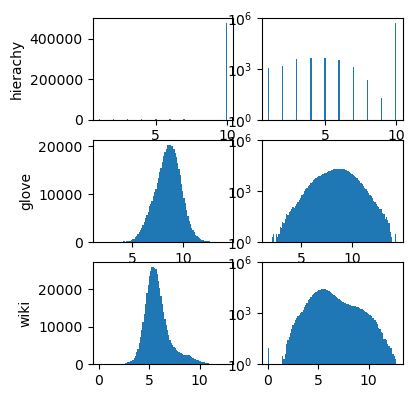

In [64]:
def plot_distinance_distribution(ax, k, v, log_scale=False):
    lower_triangle_flattened = np.tril(v, k=-1).flatten()
    ax.hist(lower_triangle_flattened[lower_triangle_flattened.nonzero()[0]], bins=100)
    if log_scale:
        ax.set_yscale('log')
        ax.set_ylim(1, 1e6)
        # ax.set_title(f"(log scale)") 
    else:
        # ax.set_title(f"Distance matrix: {k}")
        ax.set_ylabel(k)
        # ax.set_ylim(0, 1e5)

fig, axs = plt.subplots(3, 2, figsize=(4, 4.5))

for i, (k, v) in enumerate(distances_dict.items()):
    plot_distinance_distribution(axs[i, 0], k, v, log_scale=False)
    plot_distinance_distribution(axs[i, 1], k, v, log_scale=True)

tikzplotlib.save(f"{FIGURES_DIR}/dist_raw.tex", axis_height='4cm', axis_width='4.5cm')

Mantel test for distance matrices correlations. Mantel test requires zeros on diagonal.

In [65]:
for k, v in distances_dict.items():
    print(f'Non-zero count in {k:8}: {np.count_nonzero(v)}, on diag: {np.count_nonzero(np.diagonal(v)):4}, total {v.size}')

Non-zero count in hierachy: 999000, on diag:    0, total 1000000
Non-zero count in glove   : 998996, on diag:    0, total 1000000
Non-zero count in wiki    : 999000, on diag:    0, total 1000000


In [66]:
print("KG$_{1}$ & KG$_{1}$ & correlation & p-value & n \\\\")
for x, y in list(combinations(distances_dict.items(), 2)):
    corr, p, n = mantel(x[1], y[1])
    print(f"{x[0]:10} & {y[0]:10} & {corr:.2f} & {p} & {n} \\\\")

KG$_{1}$ & KG$_{1}$ & correlation & p-value & n \\
hierachy   & glove      & 0.14 & 0.001 & 1000 \\
hierachy   & wiki       & 0.13 & 0.001 & 1000 \\
glove      & wiki       & 0.16 & 0.001 & 1000 \\


## Transformations from `utils.py`

In [67]:
NUM_VALID=196+300+311
coefficient_glove = .4
coefficient_hierarchy = .5

kg_ratio = 100
use_all_base = True
label_idx_file = f"{PROJECT_DIR}/DataSplit/KGTN/label_idx.json"
testsetup = 1

def get_ignore_ind(testsetup = 1, use_all_base = use_all_base, label_idx_file = label_idx_file):
    with open(label_idx_file, 'r') as f:
        lowshotmeta = json.load(f)
    novel_classes = lowshotmeta['novel_classes_1']
    novel2_classes = lowshotmeta['novel_classes_2']
    base_classes = lowshotmeta['base_classes_1']
    base2_classes = lowshotmeta['base_classes_2']
    if testsetup:
        if use_all_base:
            ignore_ind = novel_classes 
            valid_nodes = novel2_classes + base2_classes + base_classes
        else:
            ignore_ind = novel_classes + base_classes
            valid_nodes = novel2_classes + base2_classes
    else:
        if use_all_base:
            ignore_ind = novel2_classes
            valid_nodes = novel_classes + base2_classes + base_classes
        else:
            ignore_ind = novel2_classes + base2_classes
            valid_nodes = novel_classes + base_classes
    return ignore_ind, valid_nodes


def process_semantic(mat, coefficient, kg_ratio):
    ignore_ind, _ = get_ignore_ind()
    num_classes = mat.shape[0]
    mat[range(num_classes), range(num_classes)] = 999
    min_mat = np.min(mat, 1) 
    mat = mat - min_mat.reshape(-1, 1) + 1

    in_matrix = coefficient ** (mat - 1)
    in_matrix[:, ignore_ind] = 0
    in_matrix[ignore_ind, :] = 0
    in_matrix[range(num_classes), range(num_classes)] = 2
        
    # in the ascent order
    topk = int(NUM_VALID * kg_ratio / 100)
    max_ = -np.sort(-in_matrix, 1)
    edge = max_[:, topk].reshape(-1, 1)
    in_matrix[in_matrix < edge] = 0

    return in_matrix


def process_wordnet(mat, coefficient, kg_ratio):
    ignore_ind, _ = get_ignore_ind()
    num_classes = mat.shape[0]
    in_matrix = coefficient ** (mat - 1)
    in_matrix[range(num_classes), range(num_classes)] = 2
    in_matrix[ignore_ind, :] = 0
    in_matrix[:, ignore_ind] = 0
    # in the ascent order
    topk = int(NUM_VALID * kg_ratio / 100)
    max_ = -np.sort(-in_matrix, 1)
    edge = max_[:, topk].reshape(-1, 1)
    in_matrix[in_matrix < edge] = 0
    return in_matrix

distances_dict_processed = {
    'hierachy': process_wordnet(np.copy(distances_hierarchy), coefficient=coefficient_hierarchy, kg_ratio=kg_ratio),
    'glove': process_semantic(np.copy(distances_glove), coefficient=coefficient_glove, kg_ratio=kg_ratio),
    'wiki': process_semantic(np.copy(distances_wikidata), coefficient=.32, kg_ratio=kg_ratio),
}


In [68]:
print(f" & Min & Avg & Max & Std \\\\")
for k, v in distances_dict_processed.items():
    print(f"{k:10} & {v.min():3.2f} & {v.mean():3.2f} & {v.max():3.2f} & {v.std():3.2f} \\\\")

 & Min & Avg & Max & Std \\
hierachy   & 0.00 & 0.01 & 2.00 & 0.07 \\
glove      & 0.00 & 0.05 & 2.00 & 0.11 \\
wiki       & 0.00 & 0.08 & 2.00 & 0.14 \\


With coefficient $=.32$, glove and wikidata distributions resemble themselves

In [69]:
# def plot_distinance_distribution(ax, k, v, log_scale=False):
lll = np.tril(distances_dict_processed['wiki'], k=-1).flatten()
lll_nz = lll[lll.nonzero()[0]]
(np.log(lll_nz) == 0.).sum()
# lll_nz
# (np.log(lll) == 1.).sum()
#     ax.hist(lower_triangle_flattened[lower_triangle_flattened.nonzero()[0]], bins=100)
#     if log_scale:
#         ax.set_yscale('log')
#         ax.set_ylim(1, 1e6)
#         ax.set_title(f"(log scale)") 
#     else:
#         # ax.set_title(f"Distance matrix: {k}")
#         ax.set_ylabel(k)
#         # ax.set_ylim(0, 1e5)

# fig, axs = plt.subplots(3, 2, figsize=(3, 4))


233

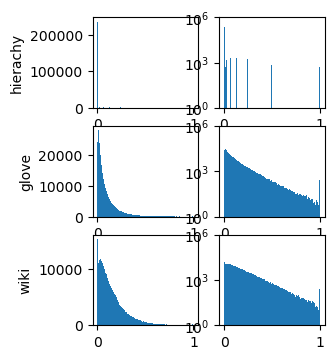

In [71]:
fig, axs = plt.subplots(3, 2, figsize=(3, 4))

for i, (k, v) in enumerate(distances_dict_processed.items()):
    plot_distinance_distribution(axs[i, 0], k, v, log_scale=False)
    plot_distinance_distribution(axs[i, 1], k, v, log_scale=True)

tikzplotlib.save(f"{FIGURES_DIR}/dist_processed.tex", axis_height='4cm', axis_width='4.5cm')

There are non-zeros on diagonal, which won't go with Mantel test

In [68]:
for k, v in distances_dict_processed.items():
    print(f'Non-zero count in {k:8}: {np.count_nonzero(v)}, on diag: {np.count_nonzero(np.diagonal(v)):4}, total {v.size}')

Non-zero count in hierachy: 490000, on diag:  700, total 1000000
Non-zero count in glove   : 490300, on diag: 1000, total 1000000
Non-zero count in wiki    : 490300, on diag: 1000, total 1000000


Let's fill diagonal with zeros (is it allowed...?)

We also copy upper traingle to lower as in [here](https://stackoverflow.com/questions/16444930/copy-upper-triangle-to-lower-triangle-in-a-python-matrix/42209263), since these matrices are not symmetric now

In [69]:
def fill_diagonal(copy, diagonal):
    np.fill_diagonal(copy, diagonal)
    return copy

def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

def fill_diag_and_make_symmetric(source):
    v = source.copy()
    v = fill_diagonal(v, 0.)
    i_lower = np.tril_indices(v.shape[0], -1)
    v[i_lower] = v.T[i_lower]
    return v

distances_dict_processed_zeros_diag = {k: fill_diag_and_make_symmetric(v) for k, v in distances_dict_processed.items()}

for k, v in distances_dict_processed_zeros_diag.items():
    print(f'Non-zero count in {k:8}: {np.count_nonzero(v)}, on diag: {np.count_nonzero(np.diagonal(v)):4}, total {v.size}, symmetric {check_symmetric(v)}')

Non-zero count in hierachy: 489300, on diag:    0, total 1000000, symmetric True
Non-zero count in glove   : 489300, on diag:    0, total 1000000, symmetric True
Non-zero count in wiki    : 489300, on diag:    0, total 1000000, symmetric True


In [70]:
print("KG$_{1}$ & KG$_{1}$ & correlation & p-value & n \\\\")
for x, y in list(combinations(distances_dict_processed_zeros_diag.items(), 2)):
    corr, p, n = mantel(x[1], y[1])
    print(f"{x[0]:10} & {y[0]:10} & {corr:.2f} & {p} & {n} \\\\")

KG$_{1}$ & KG$_{1}$ & correlation & p-value & n \\
hierachy   & glove      & 0.19 & 0.001 & 1000 \\
hierachy   & wiki       & 0.18 & 0.001 & 1000 \\
glove      & wiki       & 0.44 & 0.001 & 1000 \\


Now that's an impressive correlation between glove and wikidata